<a href="https://colab.research.google.com/github/Scilent0r/Colabs/blob/master/Image_searchengine.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Collabified version of [PyImageSearch](https://www.pyimagesearch.com/2019/08/26/building-an-image-hashing-search-engine-with-vp-trees-and-opencv/)'s image search engine

In [0]:
!wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
!tar xvzf 101_ObjectCategories.tar.gz

In [2]:
!pip install numpy
!pip install opencv-contrib-python
!pip install imutils
!pip install vptree

  Created wheel for vptree: filename=vptree-1.1.1-cp36-none-any.whl size=4380 sha256=4ff4281b7b5bef330948b3cc55a508e32a41928af8dbb30ea8a7df95d967b7f1
  Stored in directory: /root/.cache/pip/wheels/fa/87/64/b217ff173392609e0cc3a89408a12ad94764b0778fd98b8b57
Successfully built vptree


In [0]:
import numpy as np
from imutils import paths
import pickle
import vptree
import time
import cv2

Hashing functions

In [0]:
def dhash(image, hashSize=8):
	# convert the image to grayscale
	gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
	
	# resize the input image, adding a single column (width) so we
	# can compute the horizontal gradient
	resized = cv2.resize(gray, (hashSize + 1, hashSize))

	# compute the (relative) horizontal gradient between adjacent
	# column pixels
	diff = resized[:, 1:] > resized[:, :-1]

	# convert the difference image to a hash
	return sum([2 ** i for (i, v) in enumerate(diff.flatten()) if v])

def convert_hash(h):
	# convert the hash to NumPy's 64-bit float and then back to
	# Python's built in int
	return int(np.array(h, dtype="float64"))

def hamming(a, b):
	# compute and return the Hamming distance between the integers
	return bin(int(a) ^ int(b)).count("1")

Index images - Create an index of images in store to be used for searcher

In [0]:
# grab the paths to the input images and initialize the dictionary
# of hashes
imagePaths = list(paths.list_images("/content/101_ObjectCategories"))
hashes = {}

# loop over the image paths
for (i, imagePath) in enumerate(imagePaths):
	# load the input image
	print("[INFO] processing image {}/{}".format(i + 1,
		len(imagePaths)))
	image = cv2.imread(imagePath)

	# compute the hash for the image and convert it
	h = dhash(image)
	h = convert_hash(h)

	# update the hashes dictionary
	l = hashes.get(h, [])
	l.append(imagePath)
	hashes[h] = l

# build the VP-Tree
print("[INFO] building VP-Tree...")
points = list(hashes.keys())
tree = vptree.VPTree(points, hamming)

# serialize the VP-Tree to disk
print("[INFO] serializing VP-Tree...")
f = open("vptree.pickle", "wb")
f.write(pickle.dumps(tree))
f.close()

# serialize the hashes to dictionary
print("[INFO] serializing hashes...")
f = open("hashes.pickle", "wb")
f.write(pickle.dumps(hashes))
f.close()

Check output

In [6]:
!ls -l *.pickle
from google.colab.patches import cv2_imshow

-rw-r--r-- 1 root root 737438 Aug 27 08:11 hashes.pickle
-rw-r--r-- 1 root root 757447 Aug 27 08:11 vptree.pickle


Searcher - time to look for stuff

[INFO] loading VP-Tree and hashes...
This image will be searched:


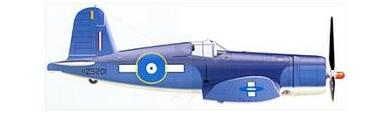

_end_
[INFO] performing search...
[INFO] search took 0.02264261245727539 seconds
[INFO] 1 total image(s) with d: 0, h: 1.4618870091351888e+19


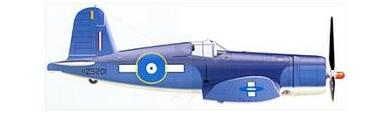

[INFO] 1 total image(s) with d: 9, h: 9.845054219648676e+18


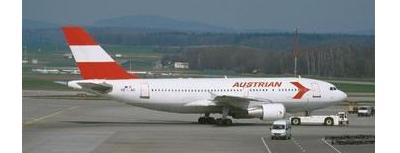

[INFO] 1 total image(s) with d: 9, h: 1.4044168316966965e+19


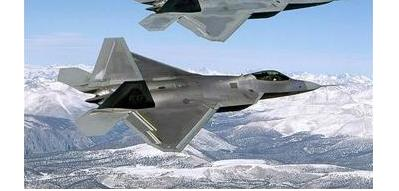

In [8]:
# python search.py --tree vptree.pickle --hashes hashes.pickle --query queries/accordion.jpg


# load the VP-Tree and hashes dictionary
print("[INFO] loading VP-Tree and hashes...")
tree = pickle.loads(open("vptree.pickle", "rb").read())
hashes = pickle.loads(open("hashes.pickle", "rb").read())

# START - load the input query image ####################################
srch = "/content/101_ObjectCategories/airplanes/image_0038.jpg"
#srch = "queries/accordion.jpg"
image = cv2.imread(srch)
print("This image will be searched:")
cv2_imshow(image)
print("_end_")
# END - load the input query image ######################################

# compute the hash for the query image, then convert it
queryHash = dhash(image)
queryHash = convert_hash(queryHash)

# perform the search
print("[INFO] performing search...")
start = time.time()
results = tree.get_all_in_range(queryHash, 10)
results = sorted(results)
end = time.time()
print("[INFO] search took {} seconds".format(end - start))

# loop over the results
for (d, h) in results:
	# grab all image paths in our dataset with the same hash
	resultPaths = hashes.get(h, [])
	print("[INFO] {} total image(s) with d: {}, h: {}".format(
		len(resultPaths), d, h))

	# loop over the result paths
	for resultPath in resultPaths:
		# load the result image and display it to our screen
		result = cv2.imread(resultPath)
		cv2_imshow(result)
		cv2.waitKey(0)